In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
np.random.seed(10)

# Load the data

We will train a regression model to predict a person's weight from their height. The model is linear regression with one explanatory variable (weight) and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

In [2]:
import datetime
from utils.helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
b.shape, A.shape

((10000,), (10000, 2))

# Least Squares Estimation
Least squares estimation is one of the fundamental machine learning algorithms. Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function $$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

We will try to fit $x$ using Least Squares Estimation. 

One can see the function is $\mu$ strongly convex with $\mu = \lambda_{max}(\nabla^2 f(x))$ and $L$ smooth with $L = \lambda_{min}(\nabla^2 f(x)$ everywhere, since here the Hessian matrix is constant, independent of $x$.



# Stochastic Gradient Descent

First define the function `minibatch_gradient` below:

In [4]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    grad = data_A.T.dot(data_A.dot(params_x)-targets_b)/data_A.shape[0]
    return grad

Verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

In [5]:

x = np.ones(A.shape[1])
full_grad = minibatch_gradient(b, A, x)
print('Gradient with complete data: ', full_grad)

mini_grads = []
for i in range(1000):
    idx = np.random.randint(0, len(b)-1)
    data_A = A[idx].reshape(1, 2)
    targets_b = b[idx].reshape(1, )
    grad = minibatch_gradient(targets_b, data_A, x)
    mini_grads.append(grad)

print('Average gradient using minibatch of size 1:', np.mean(mini_grads, axis = 0))

Gradient with complete data:  [-72.293922   -12.47971243]
Average gradient using minibatch of size 1: [-72.17774815 -12.3071268 ]


Now, implement stochastic gradient descent for Linear Least Squares, below.


In [6]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay linearly to 0 at max_iters
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    
    x = initial_x
    dataset_size = len(targets_b)
    learning_rate = initial_learning_rate
    param_states = []
    objectives = []
    for n_iter in range(max_iters):
        
        batch_grad = stochastic_gradient(targets_b, data_A, x, batch_size)

        x = x - learning_rate * batch_grad
        if decreasing_learning_rate:
            learning_rate = (1 - (1+n_iter)/max_iters)*initial_learning_rate
        
#         if n_iter % (dataset_size/batch_size) == 0:
        param_states.append(x)

        obj = 0.5/dataset_size*(np.linalg.norm(data_A.dot(x) - targets_b)**2)
        objectives.append(obj)

    return objectives, param_states

Now it is time to test the optimizer with a naive step size with the example code below.

In [7]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.2
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.152 seconds


Time Visualization

In [8]:
from utils.plots import gradient_descent_visualization
from ipywidgets import IntSlider, interact
from utils.grid_search import *

# Generate grid data for visualization (parameters to be swept and best combination)
grid_x0, grid_x1 = generate_w(num_intervals=10)
grid_objectives = grid_search(b, A, grid_x0, grid_x1)
loss_star, x0_star, x1_star = get_best_parameters(grid_x0, grid_x1, grid_objectives)

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_objectives, sgd_xs, grid_objectives, grid_x0, grid_x1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs)))

interactive(children=(IntSlider(value=1, description='n_iter', max=200, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Better Learning Rate

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq 25$ containing all iterates (and we assume $\|x-x^\star\| \leq 25$ as well, for simplicity). By $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, one can see that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top b\|)$. We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [9]:
# Define the parameters of the algorithm.
max_iters = 200

lipschitz_const = (np.linalg.norm(A.T.dot(A))*25 + np.linalg.norm(A.T.dot(b)))/len(b)
gamma =  25/(lipschitz_const*np.sqrt(max_iters)) 

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.078 seconds


# Time visualization with a better learning rate

In [10]:
interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs_dec_gamma)))

interactive(children=(IntSlider(value=1, description='n_iter', max=200, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

## SGD using strong convexity
Trying SGD with a better learning rate using the fact that the objective function is strongly convex.<br>
(We can use a decreasing stepsize parameter gamma in stochastic_gradient_descent.)

In [11]:
# Define the parameters of the algorithm.
max_iters = 200

mu = np.linalg.norm(A, -2)**2 / len(A)
L = np.linalg.norm(A, 2)**2 / len(A)

gamma0 =  2/mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.113 seconds


## Evolution of the objective function


Run the following code to compare SGD (with diffent stepsizes) and gradient descent with respect to the number of gradient computations needed per iteration (remember that gradient descent computes n gradients per iterations)

In [12]:
from utils.gradient_descent import gradient_descent
x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, 3, 1/L)

sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 0.2)
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 0.2,
    decreasing_learning_rate = True)

Gradient Descent(0/2): objective=2792.2367127591674
Gradient Descent(1/2): objective=15.3858878688294
Gradient Descent(2/2): objective=15.3858878688294


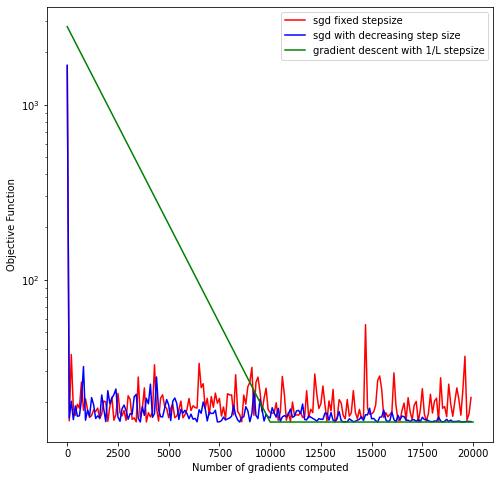

In [13]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of gradients computed')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(0,len(sgd_objectives),100),
         sgd_objectives[0:20000:100],'r', label='sgd fixed stepsize')
plt.plot(range(0,len(sgd_objectives_dec_gamma),100),
         sgd_objectives_dec_gamma[0:20000:100],'b', label='sgd with decreasing step size')
plt.plot(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives,'g', label='gradient descent with 1/L stepsize')
plt.legend(loc='upper right')
plt.show()

The above plot shows that even though the "best" and "most stable" result is obtained by gradient descent, it performs a lot many gradient computations compared to the stochastic approaches. Also, SGD with a decreases step is "more stable" compared to the one with fixed step size

# Loading more complex data
The data is taken from https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength 

In [14]:
data = np.loadtxt("data/Concrete_Data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [15]:
b.shape, A.shape

((1030,), (1030, 8))

# Running stochastic gradient descent

Testing the SGD algorithm on the new dataset.

In [16]:
max_iters = 1000

gamma =  0.001   

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.070 seconds


# Plotting the Evolution of the Objective Function

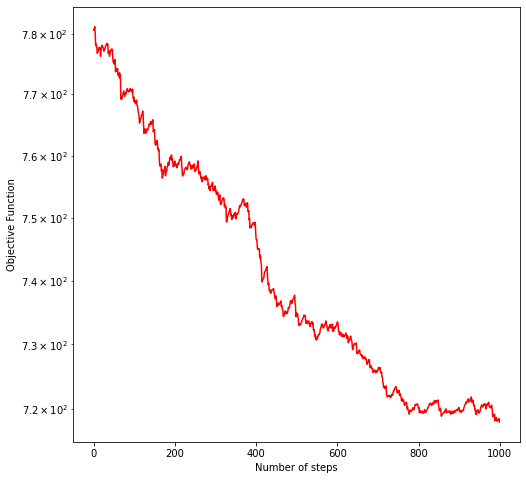

In [17]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(sgd_objectives)), sgd_objectives,'r')

plt.show()

# Projected Stochastic Gradient Descant

To avoid $x$ becoming too big, we can perform constrained optimization by projecting x onto an $\text{L}_2$ ball at each iteration, thus limiting the norm of $x$.

Define `projection` function below, which projects x onto an L2-ball:
(make sure the optimum is inside the l2-ball by choosing an appropriate radius)

In [18]:
l2_ball_radius = 4 # choose an appropriate radius
def projection(x):
    """project x onto an l2-ball"""
    
    norm_x = np.linalg.norm(x)
    
    if norm_x > l2_ball_radius:
        return x/norm_x*l2_ball_radius
    else:
        return x

Define the `projected_stochastic_gradient_descent` function below:<br>
(It is the same as stochastic_gradient_descent but with an extra step in the loop)

In [19]:
def projected_stochastic_gradient_descent(
        b, 
        A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate = False, 
        projection_fn = lambda x: x):

    """Projected gradient descent."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    x = initial_x
    dataset_size = len(b)
    learning_rate = initial_learning_rate
    xs = []
    objectives = []
    for n_iter in range(max_iters):
        
        batch_grad = stochastic_gradient(b, A, x, batch_size)

        y = x - learning_rate * batch_grad
        x = projection_fn(y) # the projection step
        if decreasing_learning_rate:
            learning_rate = (1 - (1+n_iter)/max_iters)*initial_learning_rate
        
#         if n_iter % (dataset_size/batch_size) == 0:
        xs.append(x)

        obj = 0.5/dataset_size*(np.linalg.norm(A.dot(x) - b)**2)
        objectives.append(obj)

    return objectives, xs

Test your projected SGD function

In [20]:
max_iters = 300

gamma = 0.001
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.028 seconds


Plot the error

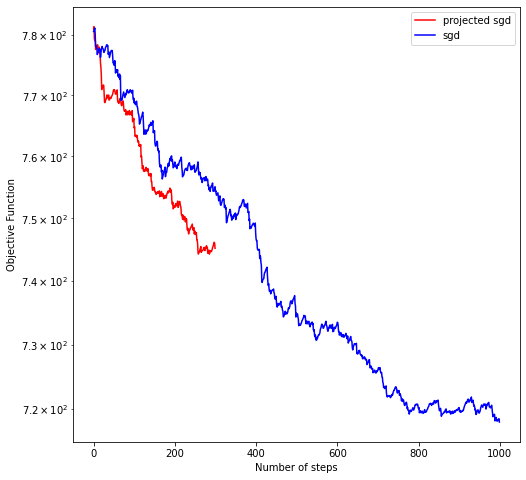

In [21]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(psgd_objectives)), psgd_objectives,'r', label='projected sgd')
plt.plot(range(len(sgd_objectives)), sgd_objectives,'b', label='sgd')
plt.legend(loc='upper right')
plt.show()

We see that the projected gradient descent decreases faster than the unconstrained SGD